In [1]:
# %matplotlib notebook
import numpy as np 
import pandas as pd
from scipy.special import gamma, factorial
import matplotlib.pyplot as plt
import pickle
import ast
import math

In [2]:
# Calculate exact
class InventoryMDP(object):
    def startState(self):
        return [0, 0]
    def orders(self, state):
        # return list of valid actions
        TopUp = list(range(21))
        result = [max(x - sum(state), 0) for x in TopUp]
        return list(set(result))
    def succProbCost(self, state, order):
        # return list of (newState, dprob, cost) triples
        # state = s, action = a, newState = s'
        # prob = T(s, a, s'), cost = Cost(s, a, s')
        c02, c03, c12, c13 = Plogit
        P2 = np.exp(c02 + c12 * order)/(1 + np.exp(c02 + c12 * order) + np.exp(c03 + c13 * order))
        P3 = np.exp(c03 + c13 * order)/(1 + np.exp(c02 + c12 * order) + np.exp(c03 + c13 * order))
        P1 = 1 - P2 - P3
        result = []
        for i in range(len(demand)):
            for y3 in range(order+1):
                for y2 in range(order-y3+1):
                    y1 = order - y3 - y2
                    # if (y1 < 0): {print('Logical Error!')}
                    newState = [0, 0]
                    newState[1] = max(state[0] + y2 - max(demand[i] - state[1] - y1, 0), 0)
                    newState[0] = max(y3 - max(demand[i] - state[0] - y2 - state[1] - y1, 0), 0)
                    cost = cs[0]*int(order>0) + cs[1]*max(order + state[0] + state[1] - demand[i], 0) + cs[2]*max(demand[i] - order - state[0] - state[1], 0) + cs[3]*max(state[1] + y1 - demand[i], 0)
                    aprob = math.factorial(order)*pow(P1,y1)*pow(P2,y2)*pow(P3,y3)/(math.factorial(y3)*math.factorial(y2)*math.factorial(y1))
                    if (demand[i] == 20):
                        dprob = 1-sum(gamma(i+size[day])*(prob[day]**size[day])*(1-prob[day])**i/(gamma(size[day])*factorial(i)) for i in range(20))
                        result.append((newState, dprob, aprob, cost))
                    else:
                        dprob = gamma(demand[i]+size[day])*(prob[day]**size[day])*(1-prob[day])**demand[i]/(gamma(size[day])*factorial(demand[i]))
                        result.append((newState, dprob, aprob, cost))
        return result
    def discount(self):
        return 0.95
    def states(self):
        return [[i, j] for i in range(21) for j in range(21-i)]

In [3]:
def Q(state, order):
    return sum(dprob * aprob * (cost + mdp.discount() * ls[4]['OVF'].iloc[(day + 1) % 7][str(newState)])
               for newState, dprob, aprob, cost in mdp.succProbCost(state, order))

## Fixed ordeing cost of $\kappa = 10$ and endogenous shelf-life uncertainty

In [52]:
open_file = open("BFA_OVF_Paper.pkl", "rb")
ls = pickle.load(open_file)
open_file.close()

In [53]:
mdp = InventoryMDP()
demand=list(range(21))
size = [3.497361, 10.985837, 7.183407, 11.064622, 5.930222, 5.473242, 2.193797]
prob = [size[0] / (size[0] + 5.660569), size[1] / (size[1] + 6.922555), size[2] / (size[2] + 6.504332),
        size[3] / (size[3] + 6.165049), size[4] / (size[4] + 5.816060), size[5] / (size[5] + 3.326408),
        size[6] / (size[6] + 3.426814)]
day=0
cs = ast.literal_eval(ls[4]['Cost'])
Plogit = ast.literal_eval(ls[4]['Endogeneity'])

### Expected cost

In [54]:
x = np.linspace(0, 10, 11)
y = np.linspace(0, 10, 11)

X, Y = np.meshgrid(x, y)
Z = np.zeros((11,11))

In [73]:
for i in np.linspace(0, 10, 11):
    for j in np.linspace(0, 10, 11):
        Z[int(i)][int(j)]= Q(state=[int(i), 8], order=int(j))

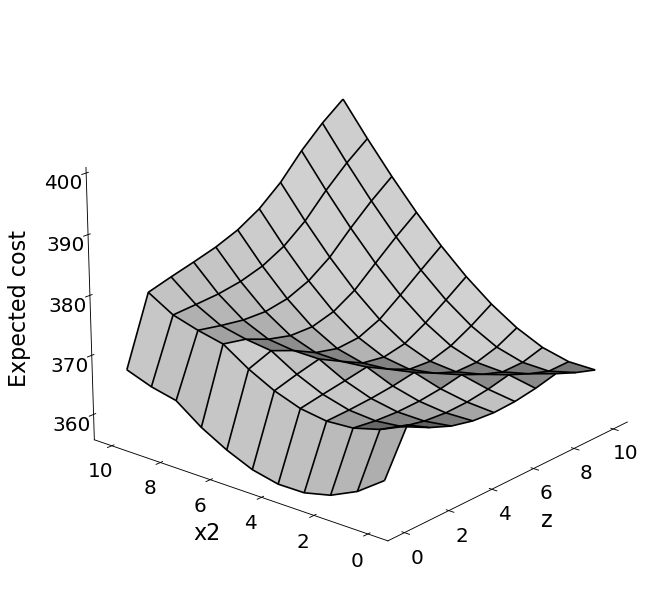

In [74]:
fig = plt.figure(figsize=(8, 8), dpi=80)
plt.rcParams['font.size'] = '18'
ax = plt.axes(projection="3d")
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.plot_surface(X, Y, Z, color='lightgrey')
ax.plot_wireframe(X, Y, Z, color='black')
ax.set_xlabel('z', labelpad=10, fontsize=20)
ax.set_ylabel('x2', labelpad=10, fontsize=20) 
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('Expected cost', labelpad=15, fontsize=20, rotation=90)
ax.set_zticks([360, 370, 380, 390, 400])
ax.view_init(20, -140)
plt.tight_layout()
plt.show()
# plt.savefig('EC_f10_Var.pdf', bbox_inches = 'tight') 

### Value function

In [75]:
x2 = np.linspace(0, 10, 11)
x1 = np.linspace(0, 10, 11)

X2, X1 = np.meshgrid(x2, x1)
V = np.zeros((11,11))

In [76]:
for i in x2:
    for j in x1:
        V[int(i)][int(j)]= ls[4]['OVF'].iloc[0][str([int(i), int(j)])]

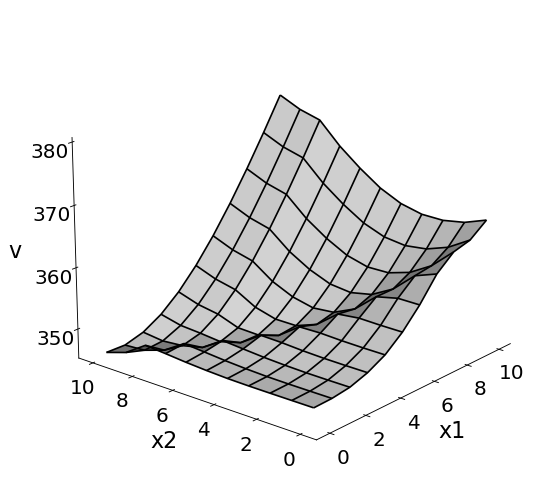

In [77]:
fig = plt.figure(figsize=(8, 8), dpi=80)
plt.rcParams['font.size'] = '18'
ax = plt.axes(projection="3d")
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.plot_surface(X2, X1, V, color='lightgrey')
ax.plot_wireframe(X2, X1, V, color='black')
ax.set_xlabel('x1',  labelpad=10, fontsize=20)
ax.set_ylabel('x2',  labelpad=10, fontsize=20)
ax.set_zlabel('v',  labelpad=10, fontsize=20)
ax.set_zticks([350, 360, 370, 380])
ax.view_init(20, -140)
plt.show()
# plt.savefig('VF_f10_Var.pdf', bbox_inches = 'tight') 

### Optimal policy

In [78]:
open_file = open("BFA_OP_Paper.pkl", "rb")
OP = pickle.load(open_file)
open_file.close()

In [79]:
x2 = np.linspace(0, 10, 11)
x1 = np.linspace(0, 10, 11)

X2, X1 = np.meshgrid(x2, x1)
P = np.zeros((11,11))

In [80]:
for i in x2:
    for j in x1:
        P[int(i)][int(j)]= pd.DataFrame(OP[4]['OP']).iloc[0][str([int(i), int(j)])]

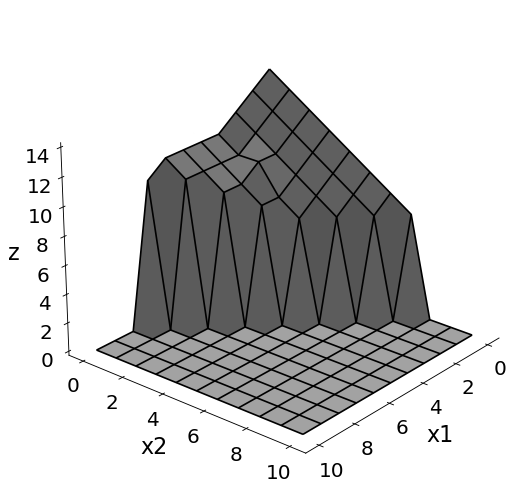

In [81]:
fig = plt.figure(figsize=(8, 8), dpi=80)
plt.rcParams['font.size'] = '18'
ax = plt.axes(projection="3d")
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.plot_surface(X2, X1, P, color='lightgrey')
ax.plot_wireframe(X2, X1, P, color='black')
ax.set_xlabel('x1', labelpad=10, fontsize=20)
ax.set_ylabel('x2', labelpad=10, fontsize=20)
ax.set_zlabel('z', labelpad=5, fontsize=20)
ax.view_init(25, 40)
plt.show()
# plt.savefig('Pi_f10_Var.pdf', bbox_inches = 'tight') 

## Zero fixed ordeing cost and endogenous shelf-life

In [82]:
open_file = open("BFA_OVF_Paper_f0.pkl", "rb")
ls = pickle.load(open_file)
open_file.close()

In [83]:
mdp = InventoryMDP()
demand=list(range(21))
size = [3.497361, 10.985837, 7.183407, 11.064622, 5.930222, 5.473242, 2.193797]
prob = [size[0] / (size[0] + 5.660569), size[1] / (size[1] + 6.922555), size[2] / (size[2] + 6.504332),
        size[3] / (size[3] + 6.165049), size[4] / (size[4] + 5.816060), size[5] / (size[5] + 3.326408),
        size[6] / (size[6] + 3.426814)]
day=0
cs = ast.literal_eval(ls[4]['Cost'])
Plogit = ast.literal_eval(ls[4]['Endogeneity'])

### Expected cost

In [86]:
x = np.linspace(0, 10, 11)
y = np.linspace(0, 10, 11)

X, Y = np.meshgrid(x, y)
Z = np.zeros((11,11))

In [87]:
for i in np.linspace(0, 10, 11):
    for j in np.linspace(0, 10, 11):
        Z[int(i)][int(j)]= Q(state=[int(i), 8], order=int(j))

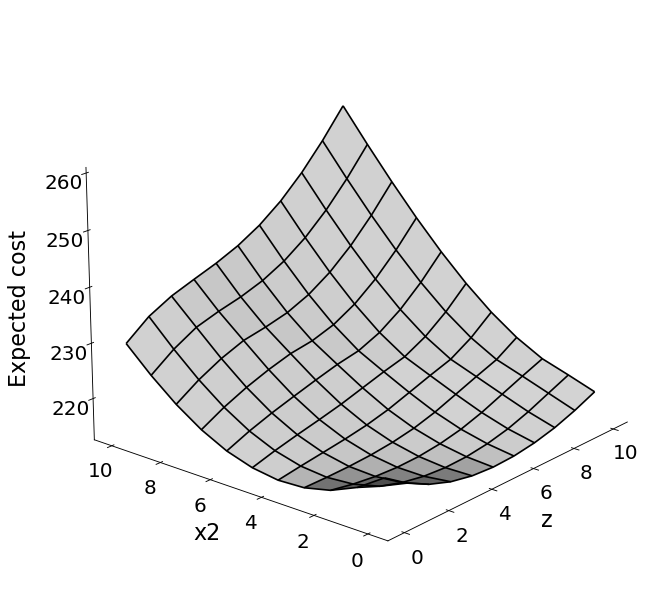

In [88]:
fig = plt.figure(figsize=(8, 8), dpi=80)
plt.rcParams['font.size'] = '18'
ax = plt.axes(projection="3d")
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.plot_surface(X, Y, Z, color='lightgrey')
ax.plot_wireframe(X, Y, Z, color='black')
ax.set_xlabel('z', labelpad=10, fontsize=20)
ax.set_ylabel('x2', labelpad=10, fontsize=20) 
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('Expected cost', labelpad=15, fontsize=20, rotation=90)
ax.set_zticks([220, 230, 240, 250, 260])
ax.view_init(20, -140)
plt.tight_layout()
plt.show()
# plt.savefig('EC_f0_Var.pdf', bbox_inches = 'tight') 

### Value function

In [89]:
x2 = np.linspace(0, 10, 11)
x1 = np.linspace(0, 10, 11)

X2, X1 = np.meshgrid(x2, x1)
V = np.zeros((11,11))

In [90]:
for i in x2:
    for j in x1:
        V[int(i)][int(j)]= ls[4]['OVF'].iloc[0][str([int(i), int(j)])]

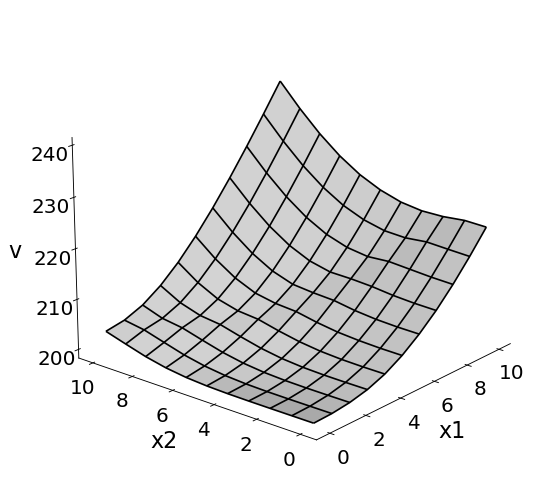

In [91]:
fig = plt.figure(figsize=(8, 8), dpi=80)
plt.rcParams['font.size'] = '18'
ax = plt.axes(projection="3d")
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.plot_surface(X2, X1, V, color='lightgrey')
ax.plot_wireframe(X2, X1, V, color='black')
ax.set_xlabel('x1',  labelpad=10, fontsize=20)
ax.set_ylabel('x2',  labelpad=10, fontsize=20)
ax.set_zlabel('v',  labelpad=10, fontsize=20)
ax.set_zticks([200, 210, 220, 230, 240])
ax.view_init(20, -140)
plt.show()
# plt.savefig('VF_f0_Var.pdf', bbox_inches = 'tight') 

### Optimal policy

In [92]:
x2 = np.linspace(0, 10, 11)
x1 = np.linspace(0, 10, 11)

X2, X1 = np.meshgrid(x2, x1)
P = np.zeros((11,11))

In [93]:
for i in x2:
    for j in x1:
        P[int(i)][int(j)]= pd.DataFrame(ls[4]['OP']).iloc[0][str([int(i), int(j)])]

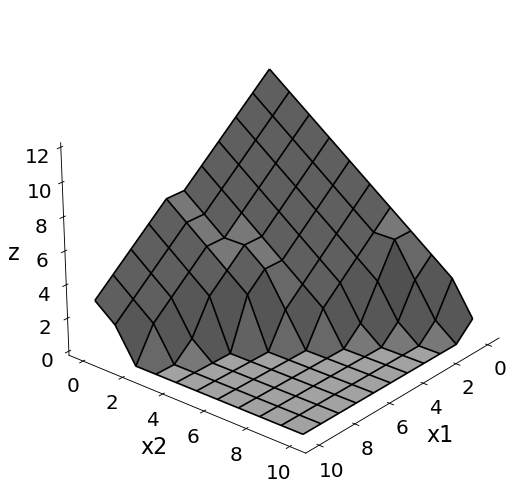

In [94]:
fig = plt.figure(figsize=(8, 8), dpi=80)
plt.rcParams['font.size'] = '18'
ax = plt.axes(projection="3d")
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.plot_surface(X2, X1, P, color='lightgrey')
ax.plot_wireframe(X2, X1, P, color='black')
ax.set_xlabel('x1', labelpad=10, fontsize=20)
ax.set_ylabel('x2', labelpad=10, fontsize=20)
ax.set_zlabel('z', labelpad=5, fontsize=20)
ax.view_init(25, 40)
plt.show()
# plt.savefig('Pi_f0_Var.pdf', bbox_inches = 'tight') 

## Zero fixed ordeing cost and deterministic shelf-life

In [103]:
# Deterministic shelf-life with m=3
class InventoryMDP(object):
    def startState(self):
        return [0, 0]
    def orders(self, state):
        # return list of valid actions
        TopUp = list(range(21))
        result = [max(x - sum(state), 0) for x in TopUp]
        return list(set(result))
    def succProbCost(self, state, order, demand, size, prob, day, cs):
        # return list of (newState, dprob, cost) triples
        # state = s, action = a, newState = s'
        # prob = T(s, a, s'), cost = Cost(s, a, s')
        result = []
        for i in range(len(demand)):
            newState = [0, 0]
            newState[1] = max(state[0] - max(demand[i] - state[1], 0), 0)
            newState[0] = max(order - max(demand[i] - state[0] - state[1], 0), 0)
            cost = cs[0]*int(order>0) + cs[1]*max(order + state[0] + state[1] - demand[i], 0) + cs[2]*max(demand[i] - order - state[0] - state[1], 0) + cs[3]*max(state[1] - demand[i], 0)
            if (demand[i] == 20):
                dprob = 1-sum(gamma(i+size[day])*(prob[day]**size[day])*(1-prob[day])**i/(gamma(size[day])*factorial(i)) for i in range(20))
                result.append((newState, dprob, cost))
            else:
                dprob = gamma(demand[i]+size[day])*(prob[day]**size[day])*(1-prob[day])**demand[i]/(gamma(size[day])*factorial(demand[i]))
                result.append((newState, dprob, cost))
        return result
    def discount(self):
        return 0.95
    def states(self):
        return [[i, j] for i in range(21) for j in range(21-i)]

In [104]:
def ValueIteration(mdp, demand, size, prob, cs):
    # initialize
    V = [{} for i in range(7)]  # state -> Vopt[state]
    for i in range(7):
        for state in mdp.states():
            V[i][str(state)] = 0.

    def Q(state, order, demand, day):
        return sum(dprob * (cost + mdp.discount() * V[(day + 1) % 7][str(newState)])
                   for newState, dprob, cost in mdp.succProbCost(state, order, demand, size, prob, day, cs))

    day = 0
    # compute the new values (newV) given the old values (V)
    newV = [{} for i in range(7)]
    for i in range(7):
        for state in mdp.states():
            newV[i][str(state)] = 0.

    while True:

        for state in mdp.states():
            newV[day][str(state)] = min(Q(state, order, demand, day) for order in mdp.orders(state))

        # check for convergence
        print(max(abs(V[day][str(state)]-newV[day][str(state)]) for state in mdp.states()))
        if (day == 6):
            if max(abs(V[day][str(state)] - newV[day][str(state)]) for day in range(7) for state in mdp.states()) < 0.1:
                break
            else:
                V = newV
                day = 0
                # compute the new values (newV) given the old values (V)
                newV = [{} for i in range(7)]
                for i in range(7):
                    for state in mdp.states():
                        newV[i][str(state)] = 0.
        else:
            day += 1

    # read out policy
    pi = [{} for i in range (7)]
    for day in range (7):
        for state in mdp.states():
            pi[day][str(state)] = min((Q(state, order, demand, day), order) for order in mdp.orders(state))[1]

    return pi, V

In [105]:
m = 3
mdp = InventoryMDP()
size = [3.497361, 10.985837, 7.183407, 11.064622, 5.930222, 5.473242, 2.193797]
prob = [size[0]/(size[0]+5.660569), size[1]/(size[1]+6.922555), size[2]/(size[2]+6.504332), size[3]/(size[3]+6.165049), size[4]/(size[4]+5.816060), size[5]/(size[5]+3.326408), size[6]/(size[6]+3.426814)]
d = list(range(21))

In [106]:
DetPDic, DetVDic = ValueIteration(mdp, demand=d, size = size, prob = prob, cs = [0, 1, 20, 5])

86.09785870742856
78.47760421709046
80.99678558625574
83.01348237648803
85.11832667782186
100.04160796307048
99.44571665203861
45.48918394757103
41.46164983343263
44.27290469889172
48.0328058009364
62.27356099893007
75.71853554974162
63.65897118064008
9.26937491738466
7.858417739992294
9.223007168776928
7.945754920799375
12.476555417516517
10.405687814976579
8.213810284013032
7.465496852992715
8.761856810338088
7.548467174759438
11.852727646640716
9.885403424227768
7.80311976981244
8.80590617151546
8.306899378042473
7.132236612045915
11.207334642996244
9.352893232883972
7.409512704637166
8.365541689103821
7.089095854590568
6.169009900557711
9.62295508127881
8.308298343924925
6.73638322139108
7.687161009864994
6.435423846715146
7.639662849093284
9.137000341577043
7.889502306632025
6.350066411505509
7.302802959371789
6.113652654379436
7.2012723285758256
5.8588200220345925
7.49425268047132
6.032393271284178
6.937181505167999
5.8075293060419
6.841124248219444
5.56587749760908
8.67959548040

0.3410297175525159
0.39144934582557767
0.32792352226235266
0.3864088743549132
0.3142532200872381
0.49000653058010357
0.3239782316748858
0.37187687853435136
0.31152734614926203
0.3670884306372102
0.2985405590829373
0.46550620405108134
0.4025063190601941
0.3532830346077276
0.29595097884180177
0.34873400910532837
0.28361353112873644
0.4422308938484605
0.38238100310718437
0.30777932009115716
0.28115342989968894
0.33129730865013585
0.2694328545723579
0.4201193491560673
0.363261952951774
0.29239035408653535
0.335618882877327
0.31473244321762195
0.2559612118437826
0.3991133816981858
0.3450988553041441
0.27777083638227396
0.3188379387335374
0.26709575840473576
0.2431631512515935
0.37915771261333475
0.3278439125389241
0.2638822945632455
0.30289604179682783
0.25374097048444355
0.298995821056792
0.3601998269825799
0.31145171691198925
0.25068817983512304
0.28775123970700633
0.24105392196020148
0.2840460300039922
0.23100499368899818
0.2958791310664992
0.2381537708432404
0.27336367772159065
0.229001

### Expected cost

In [107]:
cs = [0, 1, 20, 5]
def Q(state, order, demand, day):
    return sum(dprob * (cost + mdp.discount() * DetVDic[(day + 1) % 7][str(newState)])
               for newState, dprob, cost in mdp.succProbCost(state, order, demand, size, prob, day, cs))

In [108]:
x = np.linspace(0, 10, 11)
y = np.linspace(0, 10, 11)

X, Y = np.meshgrid(x, y)
Z = np.zeros((11,11))

In [109]:
for i in np.linspace(0, 10, 11):
    for j in np.linspace(0, 10, 11):
#         Z[int(order)][int(state)]= cost_function(x=[5.0, state], y=int(order), Plogit = [1, 0.5, -0.4, -0.8], h=1, l=20, w=5, rep = 100)
        Z[int(i)][int(j)]= Q(state=[int(i), 8], order=int(j), demand=d, day=0)

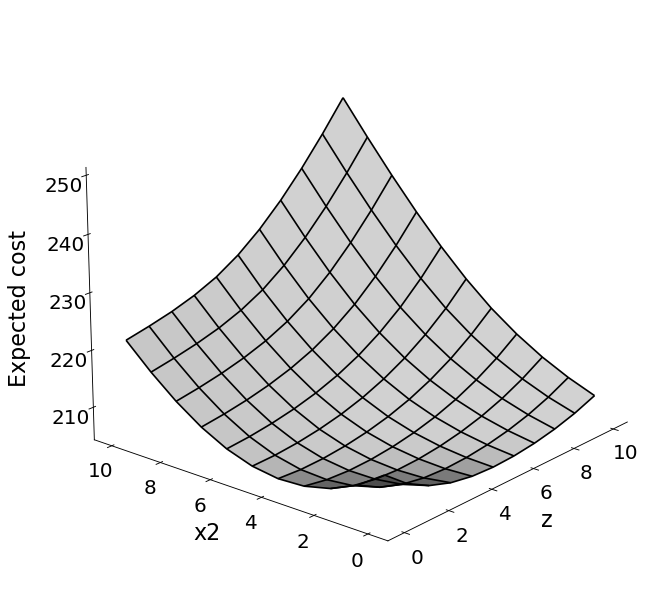

In [111]:
fig = plt.figure(figsize=(8, 8), dpi=80)
plt.rcParams['font.size'] = '18'
ax = plt.axes(projection="3d")
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.plot_surface(X, Y, Z, color='lightgrey')
ax.plot_wireframe(X, Y, Z, color='black')
ax.set_xlabel('z', labelpad=10, fontsize=20) 
ax.set_ylabel('x2', labelpad=10,fontsize=20) 
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('Expected cost', labelpad=15, fontsize=20, rotation=90)
ax.view_init(20, -140)
plt.tight_layout()
plt.show()
# plt.savefig('EC_f0_Det.pdf', bbox_inches = 'tight') 

### Value function

In [112]:
x2 = np.linspace(0, 10, 11)
x1 = np.linspace(0, 10, 11)

X2, X1 = np.meshgrid(x2, x1)
V = np.zeros((11,11))

In [113]:
for i in x2:
    for j in x1:
        V[int(i)][int(j)]= pd.DataFrame(DetVDic).iloc[0][str([int(i), int(j)])]

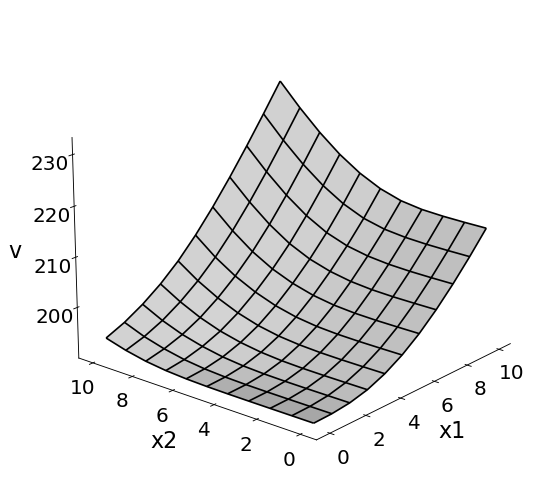

In [114]:
fig = plt.figure(figsize=(8, 8), dpi=80)
plt.rcParams['font.size'] = '18'
ax = plt.axes(projection="3d")
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.plot_surface(X2, X1, V, color='lightgrey')
ax.plot_wireframe(X2, X1, V, color='black')
ax.set_xlabel('x1',  labelpad=10, fontsize=20)
ax.set_ylabel('x2',  labelpad=10, fontsize=20)
ax.set_zlabel('v',  labelpad=10, fontsize=20)
ax.view_init(20, -140)
plt.show()
# plt.savefig('VF_f0_Det.pdf', bbox_inches = 'tight') 

### Optimal policy

In [115]:
x2 = np.linspace(0, 10, 11)
x1 = np.linspace(0, 10, 11)

X2, X1 = np.meshgrid(x2, x1)
P = np.zeros((11,11))

In [116]:
for i in x2:
    for j in x1:
        P[int(i)][int(j)]= pd.DataFrame(DetPDic).iloc[0][str([int(i), int(j)])]

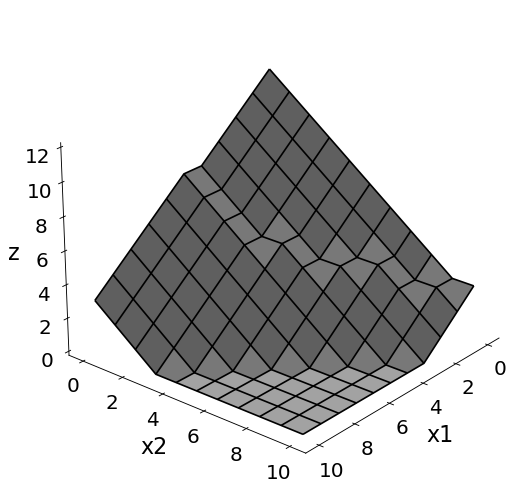

In [117]:
fig = plt.figure(figsize=(8, 8), dpi=80)
plt.rcParams['font.size'] = '18'
ax = plt.axes(projection="3d")
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.plot_surface(X2, X1, P, color='lightgrey')
ax.plot_wireframe(X2, X1, P, color='black')
ax.set_xlabel('x1',  labelpad=10, fontsize=20)
ax.set_ylabel('x2', labelpad=10, fontsize=20)
ax.set_zlabel('z', labelpad=5, fontsize=20)
ax.view_init(25, 40)
plt.show()
# plt.savefig('Pi_f0_Det.pdf', bbox_inches = 'tight') 